# First: Review Existing Unstructured Data and Diagram a New Structured Relational Data Model

Below are the libraries/packages that are going to be used throughout the assignment

In [4706]:
import json
import gzip
import shutil
import os
import pandas as pd
from tempfile import mkstemp
from shutil import move
from os import fdopen, remove
from ast import literal_eval
from datetime import datetime
from sqlalchemy import create_engine
pd.set_option("display.max_columns", None)

Since the json files were provided as zipped files or with .gz extensions that cannot be directly read by regular read_json method of pandas. To solve this issue, we first make use of gzip library to open the zipped files and check for these in our working directory using 'os' package. Once we detect them, we replace the extension of the unzipped file by reading and writing it back as .json extension which can be further read using regular read_json method.

In [4707]:
for files in os.listdir():
    if 'json' in files:
        with gzip.open(files, 'rb') as file_input:
            with open(files.replace('.gz', ''), 'wb') as file_output:
                shutil.copyfileobj(file_input, file_output)

Below all the json files are converted into a dataframe by using read_json method of pandas

In [4708]:
receipts_data = pd.read_json('receipts.json', lines=True)
brands_data = pd.read_json('brands.json',lines=True)
users_data = pd.read_json('users.json',lines=True)

In [4709]:
#receipts data exploration
receipts_data.head()

,_id,bonusPointsEarned,bonusPointsEarnedReason,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,pointsEarned,purchaseDate,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId
0,{'$oid': '5ff1e1eb0a720f0523000575'},500.0,"Receipt number 2 completed, bonus point schedu...",{'$date': 1609687531000},{'$date': 1609687531000},{'$date': 1609687531000},{'$date': 1609687536000},{'$date': 1609687531000},500.0,{'$date': 1609632000000},5.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,26.0,5ff1e1eacfcf6c399c274ae6
1,{'$oid': '5ff1e1bb0a720f052300056b'},150.0,"Receipt number 5 completed, bonus point schedu...",{'$date': 1609687483000},{'$date': 1609687483000},{'$date': 1609687483000},{'$date': 1609687488000},{'$date': 1609687483000},150.0,{'$date': 1609601083000},2.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,11.0,5ff1e194b6a9d73a3a9f1052
2,{'$oid': '5ff1e1f10a720f052300057a'},5.0,All-receipts receipt bonus,{'$date': 1609687537000},{'$date': 1609687537000},NaN,{'$date': 1609687542000},NaN,5.0,{'$date': 1609632000000},1.0,"[{'needsFetchReview': False, 'partnerItemId': ...",REJECTED,10.0,5ff1e1f1cfcf6c399c274b0b
3,{'$oid': '5ff1e1ee0a7214ada100056f'},5.0,All-receipts receipt bonus,{'$date': 1609687534000},{'$date': 1609687534000},{'$date': 1609687534000},{'$date': 1609687539000},{'$date': 1609687534000},5.0,{'$date': 1609632000000},4.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,28.0,5ff1e1eacfcf6c399c274ae6
4,{'$oid': '5ff1e1d20a7214ada1000561'},5.0,All-receipts receipt bonus,{'$date': 1609687506000},{'$date': 1609687506000},{'$date': 1609687511000},{'$date': 1609687511000},{'$date': 1609687506000},5.0,{'$date': 1609601106000},2.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,1.0,5ff1e194b6a9d73a3a9f1052


Below is the sample record of receipt item list before exploding it where we can notice how nested json is filled up in that column.

In [4710]:
receipts_data['rewardsReceiptItemList'][1]

[{'barcode': '4011',
  'description': 'ITEM NOT FOUND',
  'finalPrice': '1',
  'itemPrice': '1',
  'partnerItemId': '1',
  'quantityPurchased': 1},
 {'barcode': '028400642255',
  'description': 'DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCED FAT BAG 1 OZ',
  'finalPrice': '10.00',
  'itemPrice': '10.00',
  'needsFetchReview': True,
  'needsFetchReviewReason': 'USER_FLAGGED',
  'partnerItemId': '2',
  'pointsNotAwardedReason': 'Action not allowed for user and CPG',
  'pointsPayerId': '5332f5fbe4b03c9a25efd0ba',
  'preventTargetGapPoints': True,
  'quantityPurchased': 1,
  'rewardsGroup': 'DORITOS SPICY SWEET CHILI SINGLE SERVE',
  'rewardsProductPartnerId': '5332f5fbe4b03c9a25efd0ba',
  'userFlaggedBarcode': '028400642255',
  'userFlaggedDescription': 'DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCED FAT BAG 1 OZ',
  'userFlaggedNewItem': True,
  'userFlaggedPrice': '10.00',
  'userFlaggedQuantity': 1}]

After analysing the data, we can see that there are columns that have multiple keys and values which needs to be separated into different identifiable columns to make them as a structured data for further analysis.
Pandas DataFrame has an inbuilt method as dataframe.explode('column_name') which explodes list-likes

In [4711]:
receipts_data = receipts_data.explode('rewardsReceiptItemList')
receipts_data = receipts_data.reset_index(drop=True)
receipts_data.head()

,_id,bonusPointsEarned,bonusPointsEarnedReason,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,pointsEarned,purchaseDate,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId
0,{'$oid': '5ff1e1eb0a720f0523000575'},500.0,"Receipt number 2 completed, bonus point schedu...",{'$date': 1609687531000},{'$date': 1609687531000},{'$date': 1609687531000},{'$date': 1609687536000},{'$date': 1609687531000},500.0,{'$date': 1609632000000},5.0,"{'barcode': '4011', 'description': 'ITEM NOT F...",FINISHED,26.0,5ff1e1eacfcf6c399c274ae6
1,{'$oid': '5ff1e1bb0a720f052300056b'},150.0,"Receipt number 5 completed, bonus point schedu...",{'$date': 1609687483000},{'$date': 1609687483000},{'$date': 1609687483000},{'$date': 1609687488000},{'$date': 1609687483000},150.0,{'$date': 1609601083000},2.0,"{'barcode': '4011', 'description': 'ITEM NOT F...",FINISHED,11.0,5ff1e194b6a9d73a3a9f1052
2,{'$oid': '5ff1e1bb0a720f052300056b'},150.0,"Receipt number 5 completed, bonus point schedu...",{'$date': 1609687483000},{'$date': 1609687483000},{'$date': 1609687483000},{'$date': 1609687488000},{'$date': 1609687483000},150.0,{'$date': 1609601083000},2.0,"{'barcode': '028400642255', 'description': 'DO...",FINISHED,11.0,5ff1e194b6a9d73a3a9f1052
3,{'$oid': '5ff1e1f10a720f052300057a'},5.0,All-receipts receipt bonus,{'$date': 1609687537000},{'$date': 1609687537000},NaN,{'$date': 1609687542000},NaN,5.0,{'$date': 1609632000000},1.0,"{'needsFetchReview': False, 'partnerItemId': '...",REJECTED,10.0,5ff1e1f1cfcf6c399c274b0b
4,{'$oid': '5ff1e1ee0a7214ada100056f'},5.0,All-receipts receipt bonus,{'$date': 1609687534000},{'$date': 1609687534000},{'$date': 1609687534000},{'$date': 1609687539000},{'$date': 1609687534000},5.0,{'$date': 1609632000000},4.0,"{'barcode': '4011', 'description': 'ITEM NOT F...",FINISHED,28.0,5ff1e1eacfcf6c399c274ae6


Below is the overview of the receipts_data which indicates the number of total enteries as 64241 for 15 columns - also describes the data type, non-null value count

In [4712]:
receipts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7381 entries, 0 to 7380
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   _id                      7381 non-null   object 
 1   bonusPointsEarned        5980 non-null   float64
 2   bonusPointsEarnedReason  5980 non-null   object 
 3   createDate               7381 non-null   object 
 4   dateScanned              7381 non-null   object 
 5   finishedDate             5970 non-null   object 
 6   modifyDate               7381 non-null   object 
 7   pointsAwardedDate        6080 non-null   object 
 8   pointsEarned             6253 non-null   float64
 9   purchaseDate             6923 non-null   object 
 10  purchasedItemCount       6897 non-null   float64
 11  rewardsReceiptItemList   6941 non-null   object 
 12  rewardsReceiptStatus     7381 non-null   object 
 13  totalSpent               6946 non-null   float64
 14  userId                  

Below is the sample data for the same index after exploding that column which basically separates the data into multiple column and rows.

In [4713]:
sample_data_item_list = receipts_data.get("rewardsReceiptItemList")
sample_data_item_list[1]

{'barcode': '4011',
 'description': 'ITEM NOT FOUND',
 'finalPrice': '1',
 'itemPrice': '1',
 'partnerItemId': '1',
 'quantityPurchased': 1}

Since we know the importance of analysing the number of missing values, Nan values, NA values and their datatypes, I wrote a generic function to build a table to calulate the information for any dataframe passed.

In the first 2 lines we get the shape of the dataframe which is 49 columns and 13,643 rows and apparently, every column has missing values. Either way, we can handle them using different methods or drop them. 
Technically they cannot be counted as outliers just because the percentage is beyond the normal threshold and investigating them on what could have caused it could be determined by the way json_normalise and explode() method works. Having more number of missing values doesnt necessarily means data is bad.

In [4714]:
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
        return mz_table

In [4715]:
missing_zero_values_table(receipts_final)

Your selected dataframe has 48 columns and 227 Rows.
There are 31 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
rewardsReceiptItemList_userFlaggedDescription,0,227,100.0,227,100.0,object
rewardsReceiptItemList_originalMetaBriteBarcode,0,227,100.0,227,100.0,object
rewardsReceiptItemList_targetPrice,0,227,100.0,227,100.0,object
rewardsReceiptItemList_deleted,0,227,100.0,227,100.0,object
rewardsReceiptItemList_needsFetchReview,0,227,100.0,227,100.0,object
rewardsReceiptItemList_preventTargetGapPoints,0,227,100.0,227,100.0,object
rewardsReceiptItemList_userFlaggedBarcode,0,227,100.0,227,100.0,object
rewardsReceiptItemList_userFlaggedNewItem,0,227,100.0,227,100.0,object
rewardsReceiptItemList_userFlaggedPrice,0,227,100.0,227,100.0,object
rewardsReceiptItemList_userFlaggedQuantity,0,227,100.0,227,100.0,float64


As we can see that there are NA values in a lot of columns but currently we are looking into rewardsReceiptItemList and all the dates column. We can notice that the percentage of NA values in these columns are way high(around 50%) so we cannot drop them directly. There are different ways that NA/missingvalues can be handled. Below is one of the ways we are going to handle the date columns

In [4716]:
#all the date columns that have missing records
req_list = ['createDate', 'dateScanned','finishedDate','modifyDate','pointsAwardedDate','purchaseDate']

#for loop over the above list
for i in req_list:
    #calculating the counts of different values in a column and storing it in a variable
    res = receipts_data[i].value_counts()
    #the result is a dictionary where we need to grab the keys and feed the first one- the default is in ascending order
    #we have to handle cases where NaN values can overpower the regular non-null values
    result = res.keys()[0] if res.keys()[0] != 'NaN' else res.keys()[1]
    #filling NA values with the top results which is the MAX count(top value based on counts)
    receipts_data = receipts_data.fillna({i:f'{result}'})
    receipts_data[i] = receipts_data[i].apply(lambda x:str(x))
    receipts_data[i] = receipts_data[i].apply(literal_eval)
receipts_data = receipts_data.reset_index(drop=True)
receipts_data.head()

,_id,bonusPointsEarned,bonusPointsEarnedReason,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,pointsEarned,purchaseDate,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId
0,{'$oid': '5ff1e1eb0a720f0523000575'},500.0,"Receipt number 2 completed, bonus point schedu...",{'$date': 1609687531000},{'$date': 1609687531000},{'$date': 1609687531000},{'$date': 1609687536000},{'$date': 1609687531000},500.0,{'$date': 1609632000000},5.0,"{'barcode': '4011', 'description': 'ITEM NOT F...",FINISHED,26.0,5ff1e1eacfcf6c399c274ae6
1,{'$oid': '5ff1e1bb0a720f052300056b'},150.0,"Receipt number 5 completed, bonus point schedu...",{'$date': 1609687483000},{'$date': 1609687483000},{'$date': 1609687483000},{'$date': 1609687488000},{'$date': 1609687483000},150.0,{'$date': 1609601083000},2.0,"{'barcode': '4011', 'description': 'ITEM NOT F...",FINISHED,11.0,5ff1e194b6a9d73a3a9f1052
2,{'$oid': '5ff1e1bb0a720f052300056b'},150.0,"Receipt number 5 completed, bonus point schedu...",{'$date': 1609687483000},{'$date': 1609687483000},{'$date': 1609687483000},{'$date': 1609687488000},{'$date': 1609687483000},150.0,{'$date': 1609601083000},2.0,"{'barcode': '028400642255', 'description': 'DO...",FINISHED,11.0,5ff1e194b6a9d73a3a9f1052
3,{'$oid': '5ff1e1f10a720f052300057a'},5.0,All-receipts receipt bonus,{'$date': 1609687537000},{'$date': 1609687537000},{'$date': 1611612263000},{'$date': 1609687542000},{'$date': 1611612263000},5.0,{'$date': 1609632000000},1.0,"{'needsFetchReview': False, 'partnerItemId': '...",REJECTED,10.0,5ff1e1f1cfcf6c399c274b0b
4,{'$oid': '5ff1e1ee0a7214ada100056f'},5.0,All-receipts receipt bonus,{'$date': 1609687534000},{'$date': 1609687534000},{'$date': 1609687534000},{'$date': 1609687539000},{'$date': 1609687534000},5.0,{'$date': 1609632000000},4.0,"{'barcode': '4011', 'description': 'ITEM NOT F...",FINISHED,28.0,5ff1e1eacfcf6c399c274ae6


Here for rewardsReceiptItemList column, we cannot use the max count value strategy because we wont be able to actually decide the items in that list and substituing them with the top value isnt the best way to handle it as it can mess up the rewards which can in turn cause a loss to the company when we are not sure whether they actually bought anything or not.

In [4717]:
receipts_data = receipts_data.fillna({'rewardsReceiptItemList':'{}'})
receipts_data['rewardsReceiptItemList'] = receipts_data['rewardsReceiptItemList'].apply(lambda x:str(x))
receipts_data['rewardsReceiptItemList'] = receipts_data['rewardsReceiptItemList'].apply(literal_eval)
receipts_data = receipts_data.reset_index(drop=True)
receipts_data.head()

,_id,bonusPointsEarned,bonusPointsEarnedReason,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,pointsEarned,purchaseDate,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId
0,{'$oid': '5ff1e1eb0a720f0523000575'},500.0,"Receipt number 2 completed, bonus point schedu...",{'$date': 1609687531000},{'$date': 1609687531000},{'$date': 1609687531000},{'$date': 1609687536000},{'$date': 1609687531000},500.0,{'$date': 1609632000000},5.0,"{'barcode': '4011', 'description': 'ITEM NOT F...",FINISHED,26.0,5ff1e1eacfcf6c399c274ae6
1,{'$oid': '5ff1e1bb0a720f052300056b'},150.0,"Receipt number 5 completed, bonus point schedu...",{'$date': 1609687483000},{'$date': 1609687483000},{'$date': 1609687483000},{'$date': 1609687488000},{'$date': 1609687483000},150.0,{'$date': 1609601083000},2.0,"{'barcode': '4011', 'description': 'ITEM NOT F...",FINISHED,11.0,5ff1e194b6a9d73a3a9f1052
2,{'$oid': '5ff1e1bb0a720f052300056b'},150.0,"Receipt number 5 completed, bonus point schedu...",{'$date': 1609687483000},{'$date': 1609687483000},{'$date': 1609687483000},{'$date': 1609687488000},{'$date': 1609687483000},150.0,{'$date': 1609601083000},2.0,"{'barcode': '028400642255', 'description': 'DO...",FINISHED,11.0,5ff1e194b6a9d73a3a9f1052
3,{'$oid': '5ff1e1f10a720f052300057a'},5.0,All-receipts receipt bonus,{'$date': 1609687537000},{'$date': 1609687537000},{'$date': 1611612263000},{'$date': 1609687542000},{'$date': 1611612263000},5.0,{'$date': 1609632000000},1.0,"{'needsFetchReview': False, 'partnerItemId': '...",REJECTED,10.0,5ff1e1f1cfcf6c399c274b0b
4,{'$oid': '5ff1e1ee0a7214ada100056f'},5.0,All-receipts receipt bonus,{'$date': 1609687534000},{'$date': 1609687534000},{'$date': 1609687534000},{'$date': 1609687539000},{'$date': 1609687534000},5.0,{'$date': 1609632000000},4.0,"{'barcode': '4011', 'description': 'ITEM NOT F...",FINISHED,28.0,5ff1e1eacfcf6c399c274ae6


The data is in an unstructured format which cannot be parsed directly nor we can perform any operations so to flatten the nested json structure, we make use of json_normalize method which separates all the data in that one column,row into different columns with the prefix of its parent column.

In [4718]:
receipts_norm = pd.json_normalize(receipts_data['rewardsReceiptItemList'],errors='ignore',record_prefix='rewardsReceiptItemList')\
.add_prefix('rewardsReceiptItemList.')

In [4719]:
receipts_final = pd.merge(receipts_data, receipts_norm, left_index=True, right_index=True, how='outer')
receipts_final.head()

,_id,bonusPointsEarned,bonusPointsEarnedReason,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,pointsEarned,purchaseDate,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId,rewardsReceiptItemList.barcode,rewardsReceiptItemList.description,rewardsReceiptItemList.finalPrice,rewardsReceiptItemList.itemPrice,rewardsReceiptItemList.needsFetchReview,rewardsReceiptItemList.partnerItemId,rewardsReceiptItemList.preventTargetGapPoints,rewardsReceiptItemList.quantityPurchased,rewardsReceiptItemList.userFlaggedBarcode,rewardsReceiptItemList.userFlaggedNewItem,rewardsReceiptItemList.userFlaggedPrice,rewardsReceiptItemList.userFlaggedQuantity,rewardsReceiptItemList.needsFetchReviewReason,rewardsReceiptItemList.pointsNotAwardedReason,rewardsReceiptItemList.pointsPayerId,rewardsReceiptItemList.rewardsGroup,rewardsReceiptItemList.rewardsProductPartnerId,rewardsReceiptItemList.userFlaggedDescription,rewardsReceiptItemList.originalMetaBriteBarcode,rewardsReceiptItemList.originalMetaBriteDescription,rewardsReceiptItemList.brandCode,rewardsReceiptItemList.competitorRewardsGroup,rewardsReceiptItemList.discountedItemPrice,rewardsReceiptItemList.originalReceiptItemText,rewardsReceiptItemList.itemNumber,rewardsReceiptItemList.originalMetaBriteQuantityPurchased,rewardsReceiptItemList.pointsEarned,rewardsReceiptItemList.targetPrice,rewardsReceiptItemList.competitiveProduct,rewardsReceiptItemList.originalFinalPrice,rewardsReceiptItemList.originalMetaBriteItemPrice,rewardsReceiptItemList.deleted,rewardsReceiptItemList.priceAfterCoupon,rewardsReceiptItemList.metabriteCampaignId
0,{'$oid': '5ff1e1eb0a720f0523000575'},500.0,"Receipt number 2 completed, bonus point schedu...",{'$date': 1609687531000},{'$date': 1609687531000},{'$date': 1609687531000},{'$date': 1609687536000},{'$date': 1609687531000},500.0,{'$date': 1609632000000},5.0,"{'barcode': '4011', 'description': 'ITEM NOT F...",FINISHED,26.0,5ff1e1eacfcf6c399c274ae6,4011,ITEM NOT FOUND,26.00,26.00,False,1,True,5.0,4011,True,26.00,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,{'$oid': '5ff1e1bb0a720f052300056b'},150.0,"Receipt number 5 completed, bonus point schedu...",{'$date': 1609687483000},{'$date': 1609687483000},{'$date': 1609687483000},{'$date': 1609687488000},{'$date': 1609687483000},150.0,{'$date': 1609601083000},2.0,"{'barcode': '4011', 'description': 'ITEM NOT F...",FINISHED,11.0,5ff1e194b6a9d73a3a9f1052,4011,ITEM NOT FOUND,1,1,NaN,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,{'$oid': '5ff1e1bb0a720f052300056b'},150.0,"Receipt number 5 completed, bonus point schedu...",{'$date': 1609687483000},{'$date': 1609687483000},{'$date': 1609687483000},{'$date': 1609687488000},{'$date': 1609687483000},150.0,{'$date': 1609601083000},2.0,"{'barcode': '028400642255', 'description': 'DO...",FINISHED,11.0,5ff1e194b6a9d73a3a9f1052,028400642255,DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCE...,10.00,10.00,True,2,True,1.0,028400642255,True,10.00,1.0,USER_FLAGGED,Action not allowed for user and CPG,5332f5fbe4b03c9a25efd0ba,DORITOS SPICY SWEET CHILI SINGLE SERVE,5332f5fbe4b03c9a25efd0ba,DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCE...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,{'$oid': '5ff1e1f10a720f052300057a'},5.0,All-receipts receipt bonus,{'$date': 1609687537000},{'$date': 1609687537000},{'$date': 1611612263000},{'$date': 1609687542000},{'$date': 1611612263000},5.0,{'$date': 1609632000000},1.0,"{'needsFetchReview': False, 'partnerItemId': '...",REJECTED,10.0,5ff1e1f1cfcf6c399c274b0b,NaN,NaN,NaN,NaN,False,1,True,NaN,4011,True,26.00,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,{'$oid': '5ff1e1ee0a7214ada100056f'},5.0,All-receipts receipt bonus,{'$date': 1609687534000},{'$date': 1609687534000},{'$date': 1609687534000},{'$date': 1609687539000},{'$date': 1609687534000},5.0,{'$dat

In [4720]:
receipts_final['rewardsReceiptStatus'].value_counts()

FINISHED     5920
FLAGGED       810
SUBMITTED     434
REJECTED      167
PENDING        50
Name: rewardsReceiptStatus, dtype: int64

In [4721]:
receipts_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7381 entries, 0 to 7380
Data columns (total 49 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   _id                                                        7381 non-null   object 
 1   bonusPointsEarned                                          5980 non-null   float64
 2   bonusPointsEarnedReason                                    5980 non-null   object 
 3   createDate                                                 7381 non-null   object 
 4   dateScanned                                                7381 non-null   object 
 5   finishedDate                                               7381 non-null   object 
 6   modifyDate                                                 7381 non-null   object 
 7   pointsAwardedDate                                          7381 non-null   object 
 8   pointsEa

Now all the columns have 1 dictionary key:value pair, we will extract them using set funtion.

In [4722]:
required_list = ['_id','createDate','dateScanned','finishedDate','modifyDate','pointsAwardedDate','purchaseDate']

for req_items in required_list:
    set().union(*(k.keys() for k in receipts_final[req_items]))

{'$oid'}

{'$date'}

{'$date'}

{'$date'}

{'$date'}

{'$date'}

{'$date'}

The dates provided to us in the data are in UTC format which is hard to follow so we will convert it into datetime using datetime library with utcfromtimestamp() method

In [4723]:
def date_converter(x):
  try:
    return(datetime.utcfromtimestamp(int(x['$date'])/1000).strftime('%Y-%m-%d %H:%M:%S'))
  except TypeError:
    return(None)

In [4724]:
receipts_final['_id'] = receipts_final['_id'].apply(lambda x: x['$oid'])
receipts_final['createDate'] = receipts_final['createDate'].apply(lambda x: date_converter(x))
receipts_final['dateScanned'] = receipts_final['dateScanned'].apply(lambda x: date_converter(x))
receipts_final['finishedDate'] = receipts_final['finishedDate'].apply(lambda x: date_converter(x))
receipts_final['modifyDate'] = receipts_final['modifyDate'].apply(lambda x: date_converter(x))
receipts_final['pointsAwardedDate'] = receipts_final['pointsAwardedDate'].apply(lambda x: date_converter(x))
receipts_final['purchaseDate'] = receipts_final['purchaseDate'].apply(lambda x: date_converter(x))

In [4725]:
receipts_final = receipts_final.reset_index(drop=True)
receipts_final.head()

,_id,bonusPointsEarned,bonusPointsEarnedReason,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,pointsEarned,purchaseDate,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId,rewardsReceiptItemList.barcode,rewardsReceiptItemList.description,rewardsReceiptItemList.finalPrice,rewardsReceiptItemList.itemPrice,rewardsReceiptItemList.needsFetchReview,rewardsReceiptItemList.partnerItemId,rewardsReceiptItemList.preventTargetGapPoints,rewardsReceiptItemList.quantityPurchased,rewardsReceiptItemList.userFlaggedBarcode,rewardsReceiptItemList.userFlaggedNewItem,rewardsReceiptItemList.userFlaggedPrice,rewardsReceiptItemList.userFlaggedQuantity,rewardsReceiptItemList.needsFetchReviewReason,rewardsReceiptItemList.pointsNotAwardedReason,rewardsReceiptItemList.pointsPayerId,rewardsReceiptItemList.rewardsGroup,rewardsReceiptItemList.rewardsProductPartnerId,rewardsReceiptItemList.userFlaggedDescription,rewardsReceiptItemList.originalMetaBriteBarcode,rewardsReceiptItemList.originalMetaBriteDescription,rewardsReceiptItemList.brandCode,rewardsReceiptItemList.competitorRewardsGroup,rewardsReceiptItemList.discountedItemPrice,rewardsReceiptItemList.originalReceiptItemText,rewardsReceiptItemList.itemNumber,rewardsReceiptItemList.originalMetaBriteQuantityPurchased,rewardsReceiptItemList.pointsEarned,rewardsReceiptItemList.targetPrice,rewardsReceiptItemList.competitiveProduct,rewardsReceiptItemList.originalFinalPrice,rewardsReceiptItemList.originalMetaBriteItemPrice,rewardsReceiptItemList.deleted,rewardsReceiptItemList.priceAfterCoupon,rewardsReceiptItemList.metabriteCampaignId
0,5ff1e1eb0a720f0523000575,500.0,"Receipt number 2 completed, bonus point schedu...",2021-01-03 15:25:31,2021-01-03 15:25:31,2021-01-03 15:25:31,2021-01-03 15:25:36,2021-01-03 15:25:31,500.0,2021-01-03 00:00:00,5.0,"{'barcode': '4011', 'description': 'ITEM NOT F...",FINISHED,26.0,5ff1e1eacfcf6c399c274ae6,4011,ITEM NOT FOUND,26.00,26.00,False,1,True,5.0,4011,True,26.00,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5ff1e1bb0a720f052300056b,150.0,"Receipt number 5 completed, bonus point schedu...",2021-01-03 15:24:43,2021-01-03 15:24:43,2021-01-03 15:24:43,2021-01-03 15:24:48,2021-01-03 15:24:43,150.0,2021-01-02 15:24:43,2.0,"{'barcode': '4011', 'description': 'ITEM NOT F...",FINISHED,11.0,5ff1e194b6a9d73a3a9f1052,4011,ITEM NOT FOUND,1,1,NaN,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5ff1e1bb0a720f052300056b,150.0,"Receipt number 5 completed, bonus point schedu...",2021-01-03 15:24:43,2021-01-03 15:24:43,2021-01-03 15:24:43,2021-01-03 15:24:48,2021-01-03 15:24:43,150.0,2021-01-02 15:24:43,2.0,"{'barcode': '028400642255', 'description': 'DO...",FINISHED,11.0,5ff1e194b6a9d73a3a9f1052,028400642255,DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCE...,10.00,10.00,True,2,True,1.0,028400642255,True,10.00,1.0,USER_FLAGGED,Action not allowed for user and CPG,5332f5fbe4b03c9a25efd0ba,DORITOS SPICY SWEET CHILI SINGLE SERVE,5332f5fbe4b03c9a25efd0ba,DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCE...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5ff1e1f10a720f052300057a,5.0,All-receipts receipt bonus,2021-01-03 15:25:37,2021-01-03 15:25:37,2021-01-25 22:04:23,2021-01-03 15:25:42,2021-01-25 22:04:23,5.0,2021-01-03 00:00:00,1.0,"{'needsFetchReview': False, 'partnerItemId': '...",REJECTED,10.0,5ff1e1f1cfcf6c399c274b0b,NaN,NaN,NaN,NaN,False,1,True,NaN,4011,True,26.00,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5ff1e1ee0a7214ada100056f,5.0,All-receipts receipt bonus,2021-01-03 15:25:34,2021-01-03 15:25:34,2021-01-03 15:25:34,2021-01-03 15:25:39,2021-01-03 15:25:34,5.0,2021-01-03 00:00:00,4.0,"{'barcode': '4011', 'description': 'ITEM NOT F...",FINISHED,28.0,5ff1e1eacfcf6c399c274ae6,4011,ITEM NOT FOUND,28.00,28.00,False,1,True,4.0,4011,True,28.00,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN

To check which columns are unique and which are not, this small for loop conveys us the way these tables would be connected to each other.

In [4726]:
receipts_final = receipts_final.drop(columns=['rewardsReceiptItemList'], axis=1)
for i in receipts_final:
    print(f"{i} - {receipts_final[i].is_unique}")

_id - False
bonusPointsEarned - False
bonusPointsEarnedReason - False
createDate - False
dateScanned - False
finishedDate - False
modifyDate - False
pointsAwardedDate - False
pointsEarned - False
purchaseDate - False
purchasedItemCount - False
rewardsReceiptStatus - False
totalSpent - False
userId - False
rewardsReceiptItemList.barcode - False
rewardsReceiptItemList.description - False
rewardsReceiptItemList.finalPrice - False
rewardsReceiptItemList.itemPrice - False
rewardsReceiptItemList.needsFetchReview - False
rewardsReceiptItemList.partnerItemId - False
rewardsReceiptItemList.preventTargetGapPoints - False
rewardsReceiptItemList.quantityPurchased - False
rewardsReceiptItemList.userFlaggedBarcode - False
rewardsReceiptItemList.userFlaggedNewItem - False
rewardsReceiptItemList.userFlaggedPrice - False
rewardsReceiptItemList.userFlaggedQuantity - False
rewardsReceiptItemList.needsFetchReviewReason - False
rewardsReceiptItemList.pointsNotAwardedReason - False
rewardsReceiptItemList.po

Below we will explore users dataset

In [4727]:
users_data.head()

,_id,active,createdDate,lastLogin,role,signUpSource,state
0,{'$oid': '5ff1e194b6a9d73a3a9f1052'},True,{'$date': 1609687444800},{'$date': 1609687537858},consumer,Email,WI
1,{'$oid': '5ff1e194b6a9d73a3a9f1052'},True,{'$date': 1609687444800},{'$date': 1609687537858},consumer,Email,WI
2,{'$oid': '5ff1e194b6a9d73a3a9f1052'},True,{'$date': 1609687444800},{'$date': 1609687537858},consumer,Email,WI
3,{'$oid': '5ff1e1eacfcf6c399c274ae6'},True,{'$date': 1609687530554},{'$date': 1609687530597},consumer,Email,WI
4,{'$oid': '5ff1e194b6a9d73a3a9f1052'},True,{'$date': 1609687444800},{'$date': 1609687537858},consumer,Email,WI


The same function can be used to explore any dataset as we are here doing for users data. It has 7 columns in total with only 3 columns that need to be handled.

In [4728]:
missing_zero_values_table(users_data)

Your selected dataframe has 7 columns and 495 Rows.
There are 3 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
lastLogin,0,62,12.5,62,12.5,object
state,0,56,11.3,56,11.3,object
signUpSource,0,48,9.7,48,9.7,object


Here we are dropping the NA values to clean the dataset and keep it consistent throughout. Once we drop the NA values, we will be left with one entry of key:value pair which can be extracted using set, union and keys(). The total NA values in every column consist of only 12% on average which we can ideally drop and wont affect the data overall.

In [4729]:
req_users_list = ['_id','createdDate','lastLogin']
users_data = users_data.dropna(subset=req_users_list)
for req_items in req_users_list:
    set().union(*(k.keys() for k in users_data[req_items]))

{'$oid'}

{'$date'}

{'$date'}

applying the date convertor function to every date column

In [4730]:
users_data['_id'] = users_data['_id'].apply(lambda x: x['$oid'])
users_data['createdDate'] = users_data['createdDate'].apply(lambda x: date_converter(x))
users_data['lastLogin'] = users_data['lastLogin'].apply(lambda x: date_converter(x))
users_final = users_data.drop_duplicates()
users_final = users_final.reset_index(drop=True)
users_final.head()

,_id,active,createdDate,lastLogin,role,signUpSource,state
0,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04,2021-01-03 15:25:37,consumer,Email,WI
1,5ff1e1eacfcf6c399c274ae6,True,2021-01-03 15:25:30,2021-01-03 15:25:30,consumer,Email,WI
2,5ff1e1e8cfcf6c399c274ad9,True,2021-01-03 15:25:28,2021-01-03 15:25:28,consumer,Email,WI
3,5ff1e1b7cfcf6c399c274a5a,True,2021-01-03 15:24:39,2021-01-03 15:24:39,consumer,Email,WI
4,5ff1e1f1cfcf6c399c274b0b,True,2021-01-03 15:25:37,2021-01-03 15:25:37,consumer,Email,WI


The below code is used to find out which column has unique values and which doesnt

In [4731]:
for i in users_final:
    print(f"{i} - {users_final[i].is_unique}")

_id - True
active - False
createdDate - True
lastLogin - False
role - False
signUpSource - False
state - False


Exploring brands dataset. We can see that this also has unstructured data which will need to be flattened out using json_normalize

In [4732]:
brands_data.head()

,_id,barcode,category,categoryCode,cpg,name,topBrand,brandCode
0,{'$oid': '601ac115be37ce2ead437551'},511111019862,Baking,BAKING,"{'$id': {'$oid': '601ac114be37ce2ead437550'}, ...",test brand @1612366101024,0.0,NaN
1,{'$oid': '601c5460be37ce2ead43755f'},511111519928,Beverages,BEVERAGES,"{'$id': {'$oid': '5332f5fbe4b03c9a25efd0ba'}, ...",Starbucks,0.0,STARBUCKS
2,{'$oid': '601ac142be37ce2ead43755d'},511111819905,Baking,BAKING,"{'$id': {'$oid': '601ac142be37ce2ead437559'}, ...",test brand @1612366146176,0.0,TEST BRANDCODE @1612366146176
3,{'$oid': '601ac142be37ce2ead43755a'},511111519874,Baking,BAKING,"{'$id': {'$oid': '601ac142be37ce2ead437559'}, ...",test brand @1612366146051,0.0,TEST BRANDCODE @1612366146051
4,{'$oid': '601ac142be37ce2ead43755e'},511111319917,Candy & Sweets,CANDY_AND_SWEETS,"{'$id': {'$oid': '5332fa12e4b03c9a25efd1e7'}, ...",test brand @1612366146827,0.0,TEST BRANDCODE @1612366146827


Exploring the brandCode column which is what we are interested in. We can notice that the value of null/empty has the most counts. We can also notice a trend of brandnames which starts as "TEST BRANDCODE" with some random number(maybe system generated codes for test products). 

In [4733]:
brands_data['brandCode'].value_counts()[0:10]

                                 35
GOODNITES                         2
HUGGIES                           2
ROYAL DANSK                       1
SOL                               1
TEST BRANDCODE @1599159969725     1
WYLER'S                           1
TEST BRANDCODE @1601939762943     1
FAT RABBIT                        1
TOTAL                             1
Name: brandCode, dtype: int64

To handle the test brandcodes, I have replaced them into one common as test brandcode and grouped to differentiate among other valid brandcodes.

In [4734]:
brands_data.brandCode = brands_data.brandCode.apply(lambda x: 'TEST BRANDCODE' if 'TEST BRANDCODE' in str(x) else x)

In [4735]:
brands_data['brandCode'].value_counts()[0:10]

TEST BRANDCODE        357
                       35
GOODNITES               2
HUGGIES                 2
TOTAL                   1
MALIBU® STRAWBERRY      1
REDBREAST 12YO          1
SOL                     1
WYLER'S                 1
FAT RABBIT              1
Name: brandCode, dtype: int64

In [4736]:
missing_zero_values_table(brands_data)

Your selected dataframe has 8 columns and 1167 Rows.
There are 4 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
categoryCode,0,650,55.7,650,55.7,object
topBrand,524,612,52.4,1136,97.3,float64
brandCode,0,234,20.1,234,20.1,object
category,0,155,13.3,155,13.3,object


Extracting the keys from the cpg (consumer packaged goods) rows

In [4737]:
set().union(*(k.keys() for k in brands_data['cpg']))

{'$id', '$ref'}

Normalising the nested json data in cpg

In [4738]:
brands_norm = pd.json_normalize(brands_data['cpg'])
brands_norm = brands_norm.add_prefix('cpg.')

In [4739]:
brands_final = pd.merge(brands_data, brands_norm, left_index=True, right_index=True, how='outer')

NOTE- empty values cannot be dropped directly using dropna method because of the way it treats NA and empty values separately. 
So we will convert the empty data to NaN and then dropna.

In [4740]:
nan_value = float("NaN")
#Convert NaN values to empty string
brands_final = brands_final.replace("", nan_value)
brands_final = brands_final.dropna(subset=['brandCode'])

In [4741]:
brands_final['brandCode'].value_counts()[0:10]

TEST BRANDCODE       357
GOODNITES              2
HUGGIES                2
MALIBU® PINEAPPLE      1
REDBREAST 12YO         1
SOL                    1
WYLER'S                1
FAT RABBIT             1
TOTAL                  1
PURE BLISS             1
Name: brandCode, dtype: int64

In [4742]:
brands_final['_id'] = brands_final['_id'].apply(lambda x: x['$oid'])

Exploding "cpg" column to extract rest of the data

In [4743]:
brands_final = brands_final.explode('cpg')
brands_final = brands_final.reset_index(drop=True)
brands_final.head()

,_id,barcode,category,categoryCode,cpg,name,topBrand,brandCode,cpg.$ref,cpg.$id.$oid
0,601c5460be37ce2ead43755f,511111519928,Beverages,BEVERAGES,$id,Starbucks,0.0,STARBUCKS,Cogs,5332f5fbe4b03c9a25efd0ba
1,601c5460be37ce2ead43755f,511111519928,Beverages,BEVERAGES,$ref,Starbucks,0.0,STARBUCKS,Cogs,5332f5fbe4b03c9a25efd0ba
2,601ac142be37ce2ead43755d,511111819905,Baking,BAKING,$id,test brand @1612366146176,0.0,TEST BRANDCODE,Cogs,601ac142be37ce2ead437559
3,601ac142be37ce2ead43755d,511111819905,Baking,BAKING,$ref,test brand @1612366146176,0.0,TEST BRANDCODE,Cogs,601ac142be37ce2ead437559
4,601ac142be37ce2ead43755a,511111519874,Baking,BAKING,$id,test brand @1612366146051,0.0,TEST BRANDCODE,Cogs,601ac142be37ce2ead437559


after exploding and normalising that column, its important to drop it so the whole data stays sturctured

In [4744]:
brands_final = brands_final.drop(columns=['cpg'],axis=1)
brands_final = brands_final.reset_index(drop=True)

In [4745]:
for i in brands_final:
    print(f"{i} - {brands_final[i].is_unique}")

_id - False
barcode - False
category - False
categoryCode - False
name - False
topBrand - False
brandCode - False
cpg.$ref - False
cpg.$id.$oid - False


In [4746]:
brands_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1796 entries, 0 to 1795
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   _id           1796 non-null   object 
 1   barcode       1796 non-null   int64  
 2   category      1788 non-null   object 
 3   categoryCode  888 non-null    object 
 4   name          1796 non-null   object 
 5   topBrand      970 non-null    float64
 6   brandCode     1796 non-null   object 
 7   cpg.$ref      1796 non-null   object 
 8   cpg.$id.$oid  1796 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 126.4+ KB


In [4747]:
brands_final.head()

,_id,barcode,category,categoryCode,name,topBrand,brandCode,cpg.$ref,cpg.$id.$oid
0,601c5460be37ce2ead43755f,511111519928,Beverages,BEVERAGES,Starbucks,0.0,STARBUCKS,Cogs,5332f5fbe4b03c9a25efd0ba
1,601c5460be37ce2ead43755f,511111519928,Beverages,BEVERAGES,Starbucks,0.0,STARBUCKS,Cogs,5332f5fbe4b03c9a25efd0ba
2,601ac142be37ce2ead43755d,511111819905,Baking,BAKING,test brand @1612366146176,0.0,TEST BRANDCODE,Cogs,601ac142be37ce2ead437559
3,601ac142be37ce2ead43755d,511111819905,Baking,BAKING,test brand @1612366146176,0.0,TEST BRANDCODE,Cogs,601ac142be37ce2ead437559
4,601ac142be37ce2ead43755a,511111519874,Baking,BAKING,test brand @1612366146051,0.0,TEST BRANDCODE,Cogs,601ac142be37ce2ead437559


# ER Diagram

Below is the ER diagram of the structured data demonstrating the relationship and the cardinalities of each table. 

After exploding the nested data in columns of receipts_data and brands_data, we get multiple sub columns which narrows down all the necessary values needed to create the relationship. In receipts_data, we exploded and normalized "rewardsReceiptItemList" column and in brands_data, it was "cpg". As we can see that receipts_data and users_data both had a connection through primary key as '_id' in receipts_data, "_id" in users_data, "_id" in brands_data with "userId" being the foreign key for the respective "_id" primary for users_data. However, we notice that theres no specific key that can help relate brands_data and receipts_data since barcodes are unique per brand and NOT per item, same for brandcode and categoryCode. When cpg(consumer packaged good) was exploded, we got cpg.id.oid but it did not meet the requirements - wasnt unique. So connect them, we introduced a new column named 'brandId' as a foreign key in receipts_data to match it with the primary key '_id' in brands_data.

Now, relationship between receipts_data to users_data is "many with optional to mandatory one" because one user can have multiple receipts or no receipt but a receipt can only have one user. The relationship between receipts_data and brands_data is "many optional to many" because a receipt can have items of multiple brands or no items at all so no brand however there would be many receipts with one or many brands.

Note1 - there are many columns that are associated with 'rewardsReceiptItemList' column which are not included in this.
Note2 - There are multiple issues with '_id' in all three tables as when you explode and handle the "unstructured" data to transform it into a structured format, the '_id' no longer stays unique and cant be termed as primary keys. We can either introduce new 'ids' for every table and connect them or we as mentioned in the data dictionary that they are all UUIDs are a  universally unique identifier (UUID) - a 128-bit label used for information in computer systems, so we can replace all the repeated ones with new UUIDs to make all of them unique however, we need a lot more indepth information on how these uuids are connected to other tables along with whether they are unique to items or not. 

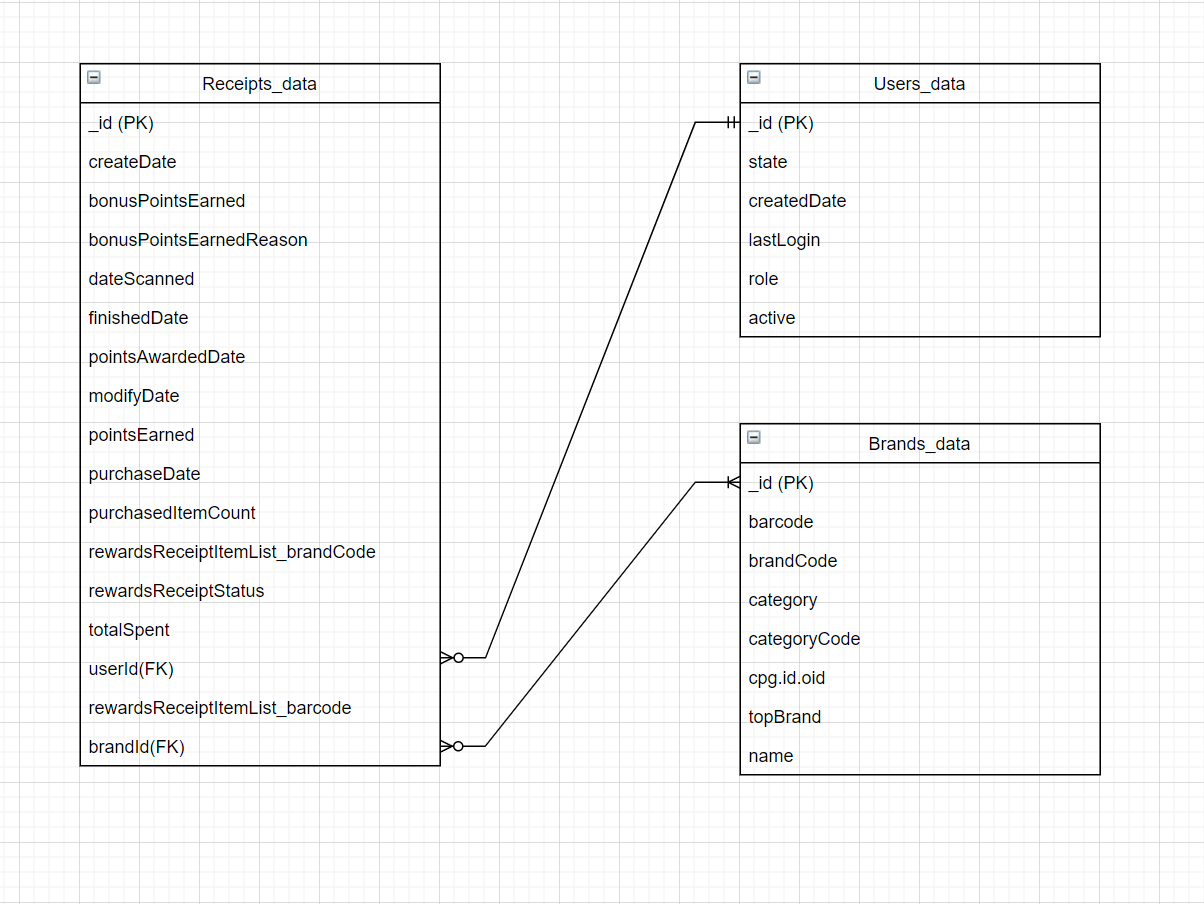

# Second: Write a query that directly answers a predetermined question from a business stakeholder

We would be using 'sqlite' throughout as an engine where we make use of sql_alchemy library to perform sql queries along with python/on dataframes.

In [4748]:
engine = create_engine('sqlite://', echo=False)
receipts_final.columns = receipts_final.columns.str.replace(".", "_")

<ipython-input-4748-dc88936c079d>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  receipts_final.columns = receipts_final.columns.str.replace(".", "_")


In [4749]:
receipts_final.to_sql('receipts',con=engine)
brands_final.to_sql('brands',con=engine)

a. When considering average spend from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?

b. When considering total number of items purchased from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?

To keep the code efficient, I have performed both of the queries in one single to reduce the redundancy and keep it clean.

The below code shows counts of unique values present in the rewardsReceiptStatus column and we can see that theres no status as "ACCEPTED" in the original dataset itself. 
Based on the data we acquired, we can calculate for ACCEPTED, assuming theres no more status apart from the below mentioned.

ACCEPTED = FINISHED - REJECTED 
assuming that receipts are flagged before being processed and final results are only accepted/rejected.

In [4750]:
receipts_data['rewardsReceiptStatus'].value_counts()

FINISHED     5920
FLAGGED       810
SUBMITTED     434
REJECTED      167
PENDING        50
Name: rewardsReceiptStatus, dtype: int64

In [4751]:
x = engine.execute("SELECT rewardsReceiptStatus as STATUS, avg(totalSpent) as AVG_SPENT, count(purchasedItemCount) as TOTAL_COUNT from receipts group by rewardsReceiptStatus;").fetchall()
x

[('FINISHED', 1244.372934121628, 5920),
 ('FLAGGED', 2635.5702469136068, 810),
 ('PENDING', 28.03244897959184, 0),
 ('REJECTED', 19.544970059880253, 167),
 ('SUBMITTED', None, 0)]

Here we have calculated the avg_spent and total_count for rejected and accepted status and can notice that status 'ACCEPTED' is greater than 'REJECTED' in both the conditions.

In [4752]:
status = pd.DataFrame(x, columns=['STATUS','AVG_SPENT','TOTAL_COUNT']).set_index("STATUS")
status.loc['ACCEPTED'] = status.apply(lambda x: x["FINISHED"]-x["REJECTED"])
status

,AVG_SPENT,TOTAL_COUNT
STATUS,,
FINISHED,1244.372934,5920.0
FLAGGED,2635.570247,810.0
PENDING,28.032449,0.0
REJECTED,19.544970,167.0
SUBMITTED,NaN,0.0
ACCEPTED,1224.827964,5753.0


# Third: Evaluate Data Quality Issues in the Data Provided

Finding the unique values of brandcodes in the receipts final dataset to compare with brands dataset

In [4753]:
receipts_final = receipts_final.dropna(subset=['rewardsReceiptItemList_brandCode'])
receipts_final = receipts_final.drop_duplicates(subset=['rewardsReceiptItemList_brandCode'])
receipts_final = receipts_final.reset_index(drop=True)
len(receipts_final.index)

227

In [4754]:
brands_final = brands_final.drop_duplicates(subset=['brandCode'])
brands_final = brands_final.reset_index(drop=True)
len(brands_final.index)

540

Copying it into a new dataframe so I dont mess with the original dataset

In [4755]:
receipts_dropped = receipts_final.copy()
receipts_dropped['rewardsReceiptItemList_brandCode'] = receipts_dropped['rewardsReceiptItemList_brandCode'].apply(lambda x:str(x))

In [4756]:
brands_final['barcode'] = brands_final['barcode'].apply(lambda x: str(x))
brands_final['brandCode'] = brands_final['brandCode'].apply(lambda x: str(x))

Here, we are extracting the brandcodes that are present in the receipts dataset and comparing it with brands dataset. We can notice that there are almost 186 brandcodes present in receipts dataset but not in brands dataset which is data quality issue and will create issues when querying through these two tables/joining them. Also for the company if their brands record doesnt have these items but are still recognised in the receipts for items. 
Note- theres a high posibility that these brandcodes could be a part of those "TEST BRANDCODE @number" present in brand codes. This can only be clear when the brands table is updated with the correct brand names.

In [4757]:
brand_code_not_included = receipts_dropped[~(receipts_dropped['rewardsReceiptItemList_brandCode'].isin(brands_final['brandCode']))]['rewardsReceiptItemList_brandCode']
#DISPLAYING ONLY TOP 10 TO NOT CLUTTER THE OUTPUT
print(brand_code_not_included[0:10])
print(len(brand_code_not_included.index))
receipts_dropped['rewardsReceiptItemList_brandCode'].is_unique
brand_code_not_included.is_unique

0               MISSION
1                 BRAND
2     KRAFT EASY CHEESE
6              WINGSTOP
7                GERM-X
8        BEN AND JERRYS
9                BORDEN
11            KLARBRUNN
12               HY-VEE
13    LIGHT & FIT GREEK
Name: rewardsReceiptItemList_brandCode, dtype: object
186


True

True

# Fourth: Communicate with Stakeholders

Hi,

This is Rishabh from the Analytics team who is responsible for processing all the incoming data, convert them into a readable format for the machine and the user to find meaningful insights. In this process, there are times we tumble across many issues related to the data/data source which I will be discussing below for receipts, users and brands dataset.

1. I tried to merge these three datasets together using the unique ids(identifier for every row) present in every table but soon noticed that there are multiple records per id("_id") after cleaning them which negates the use of having "_id" column. Receipts column had userId which can be used to relate to the users data however, there isn't any brandId which can be used to relate with brands table. So I would like to know whether the connection between these two are related to each other by any column or not, and if not, then how are we identifying the brandcode for verification and if yes, whats the field(parameter) thats being used to create the connection.

2. There were multiple data quality issues which I found and how I can fix them if I get any additional insights/data - 

    a. Id, date columns have been recorded with additional key:value pair or in a dictionary format which I did not understand the reason for it when the column/field were good enough to provide enough insight on what that coulmn is used for.
Directly storing the values as a string can reduce the processing steps, which indeed will keep the overall process optimised.

    b. Missing of brandcodes in brands dataset that are present in receipts dataset questions the relationship between these two table in case theres a need for verification/restocking/keeping count of sales per brand.
So, there are additional brandcodes named "TEST BRANDCODE @number" which can be verified to a valid brandcode in the brands table that can solve the issue of the missing/mismatch of brandcodes between these two datasets.

    c.While going through the "rewardsReceiptStatus" column, which is basically the status of the receipt through receipt validation and processing, I tried to count the number of occurrences of each status and found the following - 
FINISHED     5920
FLAGGED       810
SUBMITTED     434
REJECTED      167
PENDING        50

    The status "ACCEPTED" is no where to be found in the original dataset however, we have FINISHED status which means that the processing of these receipts for rewards has finished status. I had to make assumptions that there are no other status and only accepted/rejected status the only ones after receipt is processed completely. Accepted = Finished - Rejected. This thing could be made straightforward by adding another status as ACCEPTED to avoid us creating assumptions or invalid calculations that can create issues.

3. The consistency in data types is a very important aspect of data analysis especially while collecting and storing the data. There can be multiple production issues if there are not proper try/catch method - this is way to handle errors, foreign data type, data structure without hindering the overall process. There are times when these are not properly handled can create server issues/server stoppages. One other thing that can be added to the tables is a way to connect different tables using primary and foreign keys - which can be done during the processing and storing the data, however, proper data dictionary of what the values mean inside specific columns, such as rewards status could make things more clear.

Looking forward to discussing the above in detail.

Regards,
Rishabh